<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Lab: Fun with Neural Nets

---

Below is a procedure for building a neural network to recognize handwritten digits.  The data is from [Kaggle](https://www.kaggle.com/c/digit-recognizer/data), and you will submit your results to Kaggle to test how well you did!

1. Load the training data (`train.csv`) from [Kaggle](https://www.kaggle.com/c/digit-recognizer/data)
2. Setup X and y (feature matrix and target vector)
3. Split X and y into train and test subsets.
4. Preprocess your data

   - When dealing with image data, you need to normalize your `X` by dividing each value by the max value of a pixel (255).
   - Since this is a multiclass classification problem, keras needs `y` to be a one-hot encoded matrix
   
5. Create your network.
   - Remember that for multi-class classification you need a softmax activation function on the output layer.
   - You may want to consider using regularization or dropout to improve performance.
   
6. Train your network.
7. If you are unhappy with your model performance, try to tighten up your model by adding hidden layers, adding hidden layer units, chaining the activation functions on the hidden layers, etc.
8. Load in [Kaggle's](https://www.kaggle.com/c/digit-recognizer/data) `test.csv`
9. Create your predictions (these should be numbers in the range 0-9).
10. Save your predictions and submit them to Kaggle.

---

For this lab, you should complete the above sequence of steps for **_at least_** two of the four "configurations":

1. Using a `tensorflow` network (we did _not_ cover this in class!)
2. Using a `keras` convolutional network
3. Using a `keras` network with regularization
4. Using a `tensorflow` convolutional network (we did _not_ cover this in class!)

In [1]:
# Import libraries and modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For reproducibility
np.random.seed(42)

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, \
Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras import utils

# Prepare data

In [2]:
# Get data
df = pd.read_csv('./data/train.csv')

In [3]:
print(df.shape)
df.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Check value from training set
df.describe().T.sort_values(by='max', ascending=False)

## Now we have 784 pixel columns with 1 label column. 
# Maximum value of pixel is 255, min is 0.

,count,mean,std,min,25%,50%,75%,max
pixel352,42000.0,113.926762,110.016813,0.0,0.0,89.0,250.0,255.0
pixel444,42000.0,5.894786,33.507857,0.0,0.0,0.0,0.0,255.0
pixel446,42000.0,0.143786,5.074142,0.0,0.0,0.0,0.0,255.0
pixel717,42000.0,8.055048,39.264517,0.0,0.0,0.0,0.0,255.0
pixel451,42000.0,0.647429,10.538205,0.0,0.0,0.0,0.0,255.0
...,...,...,...,...,...,...,...,...
pixel139,42000.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
pixel731,42000.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
pixel730,42000.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
pixel729,42000.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [5]:
# Turn to numpy array and make sure that Xs are float
X = np.array(df.drop(columns=['label'])).astype('float32')

# Normalize pixel
X /= 255

# Reshape X to 28 * 28 * 1 (black/white images)
X = np.reshape(X, newshape=(X.shape[0], 28, 28, 1))

# Assign y as one-hot encoding
y = utils.to_categorical(df['label'], 10)

In [6]:
# Check X result
print(X.shape)

print('Min:', X.min())
print('Max:', X.max())

# Now our pixel data distributed from 0-1.

(42000, 28, 28, 1)
Min: 0.0
Max: 1.0


In [7]:
# Split train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Check split size
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((31500, 28, 28, 1), (10500, 28, 28, 1), (31500, 10), (10500, 10))

In [8]:
# Check class balance
# Training data
pd.DataFrame(y_train).sum() / y_train.shape[0] * 100

0     9.863492
1    11.231746
2     9.857142
3    10.158731
4     9.676190
5     9.196825
6     9.926985
7    10.368254
8     9.707936
9    10.012698
dtype: float32

In [9]:
# Test data
pd.DataFrame(y_test).sum() / y_test.shape[0] * 100

0     9.761905
1    10.914286
2    10.209524
3    10.961905
4     9.752380
5     8.552381
6     9.619047
7    10.809524
8     9.571428
9     9.847619
dtype: float32

In [10]:
# Class balance looks okay.

# Model

## Keras Network with Regulariztion

In [11]:
# Make FNNs model

# Topology
model = Sequential()

# Input layer
model.add(Flatten(input_shape=(28, 28, 1)))

# Hidden layers
model.add(Dense(128, activation='relu', input_shape=(X.shape[1],), kernel_regularizer=l2(0.01)))
model.add(Dense(28, activation='relu', kernel_regularizer=l2(0.01)))

# Output layer
model.add(Dense(10, activation='softmax'))

# Compile
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Fit
fnn_history = model.fit(X_train,
                    y_train, 
                    batch_size=512,
                    validation_data=(X_test, y_test),
                    epochs=100,
                    verbose=1)

Epoch 1/100
62/62 [==============================] - 1s 8ms/step - loss: 2.4954 - accuracy: 0.7544 - val_loss: 1.3345 - val_accuracy: 0.8875
Epoch 2/100
62/62 [==============================] - 0s 5ms/step - loss: 1.0648 - accuracy: 0.8979 - val_loss: 0.8914 - val_accuracy: 0.9030
Epoch 3/100
62/62 [==============================] - 0s 5ms/step - loss: 0.8079 - accuracy: 0.9083 - val_loss: 0.7449 - val_accuracy: 0.9105
Epoch 4/100
62/62 [==============================] - 0s 5ms/step - loss: 0.7064 - accuracy: 0.9124 - val_loss: 0.6763 - val_accuracy: 0.9130
Epoch 5/100
62/62 [==============================] - 0s 5ms/step - loss: 0.6498 - accuracy: 0.9175 - val_loss: 0.6357 - val_accuracy: 0.9164
Epoch 6/100
62/62 [==============================] - 0s 6ms/step - loss: 0.6145 - accuracy: 0.9200 - val_loss: 0.6060 - val_accuracy: 0.9170
Epoch 7/100
62/62 [==============================] - 0s 5ms/step - loss: 0.5873 - accuracy: 0.9237 - val_loss: 0.5878 - val_accuracy: 0.9185
Epoch 8/100
6

In [12]:
# Model summary
print(X_train.shape)
model.summary()

(31500, 28, 28, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 28)                3612      
                                                                 
 dense_2 (Dense)             (None, 10)                290       
                                                                 
Total params: 104,382
Trainable params: 104,382
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Create evaluation funciton
def eval_loss(history):
    """Returns accuracy and plot loss by epoch"""
    # Evaluation
    # Check out our train loss and test loss over epochs
    train_loss = history.history['loss']
    test_loss = history.history['val_loss']
    epoch_labels = history.epoch

    # Set figure size
    plt.figure(figsize=(12, 8))

    # Generate line plot
    plt.plot(train_loss, label='Training Loss')
    plt.plot(test_loss, label='Testing Loss')

    # Set title
    plt.title('Training and Testing Loss by Epoch', fontsize=25)
    plt.xlabel('Epoch', fontsize=18)
    plt.ylabel('Categorical Crossentropy', fontsize=18)

    plt.legend(fontsize=18);

    print(f"Train acc: {round(history.history['accuracy'][-1], 4)}")
    print(f"Test acc: {round(history.history['val_accuracy'][-1], 4)}")
    

Train acc: 0.969
Test acc: 0.9579


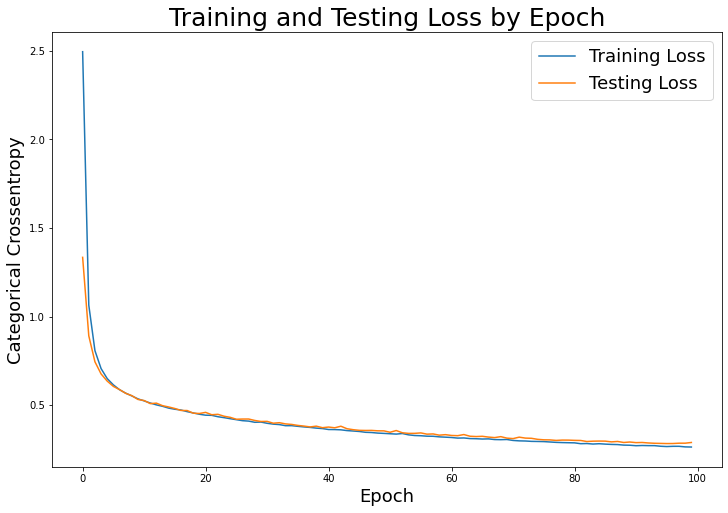

In [14]:
# Evaluation
eval_loss(fnn_history)

In [15]:
# Train and test loss tend to decrease while epochs increased
# and could be getting lower if we keep increasing epoch.

## Keras Convolutional Network

In [16]:
# Make model

# Topology
cnn_model = Sequential()

# Feature learning
## Add a convolutional layer
cnn_model.add(Conv2D(filters=6, # number of filters
                     kernel_size=(3,3), # height/width of filter
                     activation='relu', # activation function 
                     input_shape=(28,28,1) # shape of input (image)
                    ) 
             )

## Pooling
cnn_model.add(MaxPooling2D(pool_size=(2,2))) 

## Convolution layer
cnn_model.add(Conv2D(16, # number of gilters
                     kernel_size=(3,3), #
                     activation='relu'))

## Pooling
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

# Classification
## Flatten
cnn_model.add(Flatten())

## Fully connected
cnn_model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
cnn_model.add(Dense(28, activation='relu', kernel_regularizer=l2(0.01)))

## Output layer
cnn_model.add(Dense(10, activation='softmax'))



In [17]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 6)         60        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 16)        880       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 400)               0         
                                                                 
 dense_3 (Dense)             (None, 128)              

In [18]:
# Compile
cnn_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Fit
cnn_history = cnn_model.fit(X_train,
                    y_train, 
                    batch_size=512,
                    validation_data=(X_test, y_test),
                    epochs=100,
                    verbose=1)

Epoch 1/100
62/62 [==============================] - 4s 47ms/step - loss: 2.9810 - accuracy: 0.5152 - val_loss: 1.4232 - val_accuracy: 0.8218
Epoch 2/100
62/62 [==============================] - 3s 46ms/step - loss: 1.0433 - accuracy: 0.8750 - val_loss: 0.8078 - val_accuracy: 0.9092
Epoch 3/100
62/62 [==============================] - 3s 50ms/step - loss: 0.6960 - accuracy: 0.9216 - val_loss: 0.6101 - val_accuracy: 0.9310
Epoch 4/100
62/62 [==============================] - 3s 47ms/step - loss: 0.5471 - accuracy: 0.9384 - val_loss: 0.4997 - val_accuracy: 0.9425
Epoch 5/100
62/62 [==============================] - 3s 48ms/step - loss: 0.4603 - accuracy: 0.9481 - val_loss: 0.4320 - val_accuracy: 0.9497
Epoch 6/100
62/62 [==============================] - 3s 47ms/step - loss: 0.4114 - accuracy: 0.9508 - val_loss: 0.3864 - val_accuracy: 0.9553
Epoch 7/100
62/62 [==============================] - 3s 47ms/step - loss: 0.3588 - accuracy: 0.9595 - val_loss: 0.3411 - val_accuracy: 0.9626
Epoch 

Train acc: 0.9901
Test acc: 0.9862


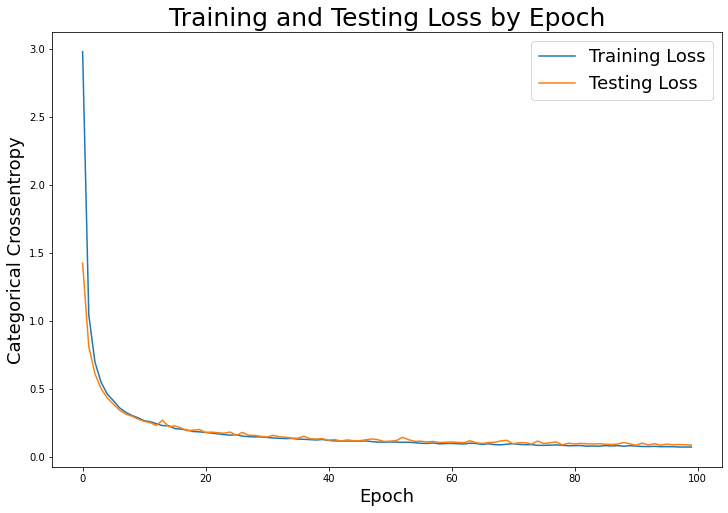

In [19]:
# Evaluation
eval_loss(cnn_history)

In [20]:
# Comparing CNNs and FNNs, CNNs is performing better.

# Prediction

In [21]:
# Submission history
## 1: CNNs model, Scores: 0.98125

In [22]:
# Prepare data

# Import data
df_submis = pd.read_csv('./data/test.csv')

# Turn to numpy array and make sure that Xs are float
X_submis = np.array(df_submis).astype('float32')

# Normalize pixel
X_submis /= 255

# Reshape X to 28 * 28 * 1 (black/white images)
X_submis = np.reshape(X_submis, newshape=(X_submis.shape[0], 28, 28, 1))

In [23]:
# Predict data
y_submis = cnn_model.predict(X_submis)

# Convert prob array to original number
y_submis = [np.where(num_list == num_list.max())[0][0] for num_list in y_submis]

# Create dataframe
df_y_submis = pd.DataFrame({'ImageId': range(1, len(y_submis)+1), 'Label': y_submis})

875/875 [==============================] - 2s 3ms/step


In [24]:
# Make submission
df_y_submis.to_csv('./digit_submis.csv', index=False)
pd.read_csv('./digit_submis.csv')

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9
